In [1]:
import itertools # confusion matrix
import string
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from Myplot import plot_confusion_matrix,plot_roc_curve,get_all_roc_coordinates
from sklearn.metrics import roc_auc_score
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [2]:
def load_data(url):
    import pandas as pd
    # Load dataset
    data = pd.read_csv(filepath_or_buffer=url,sep=',')
    data.set_index("Unnamed: 0",drop=True,inplace=True)
    return data

In [3]:
def create_splits():
    import numpy as np
    import pandas as pd
    import os
    data_path=os.getcwd()+'/Data/'
    X_train=load_data(data_path+[i for i in os.listdir(os.getcwd()+'/Data/') if 'X_train' in i][0])
    X_test=load_data(data_path+[i for i in os.listdir(os.getcwd()+'/Data/') if 'X_test' in i][0])
    y_train= np.load(data_path+[i for i in os.listdir(os.getcwd()+'/Data/') if 'y_train' in i][0])
    y_test= np.load(data_path+[i for i in os.listdir(os.getcwd()+'/Data/') if 'y_test' in i][0])
    return X_train,X_test,y_train,y_test
    

In [5]:
def training_basic_classifier(X_train,y_train):
    from xgboost import XGBClassifier
    classifier=XGBClassifier(n_estimator = 10000,learning_rate=0.10,num_leaves=30)
    classifier.fit(X_train,y_train)
    return classifier

In [6]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [7]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [8]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred,average='micro')
    recall = recall_score(y_true, y_pred,average='micro')
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [16]:
def create_confusion_matrix_plot(model, X_test, y_test):
    from sklearn.metrics import confusion_matrix
    from scikitplot.metrics import plot_confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred,labels=[0,1,2,3])
    unique_labels = ['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure']
    labels_dict = {i:unique_labels[i]  for i in range(len(unique_labels))}
    y_pred_cat = np.array([labels_dict[label] for label in y_pred])
    y_test_cat = np.array([labels_dict[label] for label in y_test])
    plot_confusion_matrix(y_test_cat, y_pred_cat)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=45)
    plt.savefig(f'confusion_matrix_{model}.png')
    plt.show()

In [17]:
def hyper_parameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import accuracy_score
    # define random parameters grid
    # Define the parameter grid to search over
    param_grid = {'XGBClassifier': [1000, 5000, 10000],'learning_rate': [0.01, 0.1, 1],'max_depth': [3, 5, 7],
                  'subsample': [0.8, 0.9, 1],'colsample_bytree': [0.8, 0.9, 1],'reg_alpha': [0, 0.1, 0.5, 1],
                  'reg_lambda': [0, 0.1, 0.5, 1],'min_child_weight': [1, 2, 4]}
    # Create a Multinomial Naive Bayes classifier
    classifier = XGBClassifier()
    # Create a GridSearchCV object and fit it to the training data
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    # Use the best estimator to make predictions on the test data
    best_params = grid_search.best_params_
    print('best_params')
    print(best_params)
    print('training data with best params')
    classifier=XGBClassifier(XGBClassifier=best_params['XGBClassifier'],learning_rate=best_params['learning_rate'],
                             max_depth=best_params['max_depth'],subsample=best_params['subsample'],
                             colsample_bytree=best_params['colsample_bytree'],reg_alpha=best_params['reg_alpha'],
                            reg_lambda=best_params['reg_lambda'],min_child_weight=best_params['min_child_weight'])
    best_classifier=classifier.fit(X_train, y_train)
    return best_classifier,best_params

In [18]:
def create_roc_auc_plot(clf,X_data,y_data):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import roc_auc_score
    from Myplot import plot_confusion_matrix,plot_roc_curve,get_all_roc_coordinates
    from warnings import filterwarnings
    filterwarnings('ignore')
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    plt.figure(figsize = (12, 8))
    bins = [i/20 for i in range(20)] + [1]
    classes = ['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure']
    xdict=dict(zip([0,1,2,3],classes))
    pred=clf.predict(X_data)
    y_data_cat=[xdict[key] for key in y_data]
    pred_cat=[xdict[key] for key in pred]
    roc_auc_ovr = {}
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_data.copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_data_cat]
        df_aux['prob'] = clf.predict_proba(X_data)[:, i]
        df_aux = df_aux.reset_index(drop = True)
    
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 4, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(c)
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")
    
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 4, i+5)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom,label=classes[i])
        ax_bottom.set_title("ROC Curve OvR")
    
       # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()
    plt.savefig(f'create_roc_auc_plot_xgb.png')

# Machine Learning Model : Naive Bayes

[12:11:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "n_estimator", "num_leaves" } are not used.

{'accuracy': 0.91, 'precision': 0.91, 'recall': 0.91, 'entropy': 0.29}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=10000, n_estimators=100,
              n_jobs=0, num_leaves=30, num_parallel_tree=1, ...)


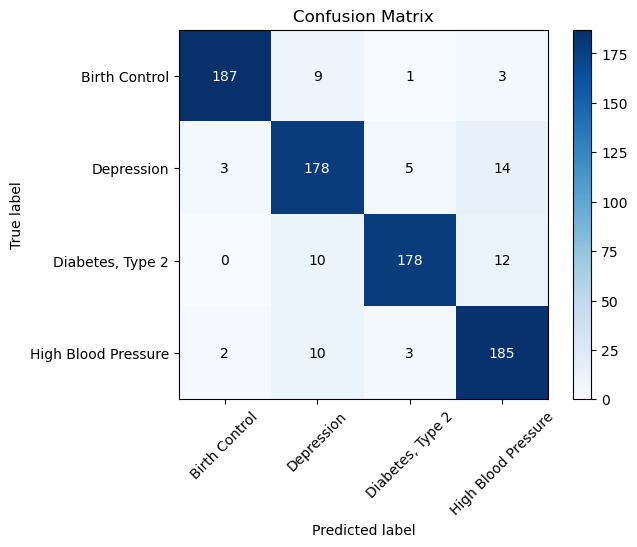

In [19]:
X_train,X_test,y_train,y_test=create_splits()
xgb=training_basic_classifier(X_train,y_train)
pred=predict_on_test_data(xgb,X_test)
pred_proba=predict_prob_on_test_data(xgb,X_test)
print(get_metrics(y_test,pred,pred_proba))
create_confusion_matrix_plot(xgb,X_test,y_test)

# Hypertune the Naive Bayes Model

best_params
{'alpha': 1.0, 'fit_prior': True}
training data with best params
{'accuracy': 0.94, 'precision': 0.94, 'recall': 0.94, 'entropy': 0.39}


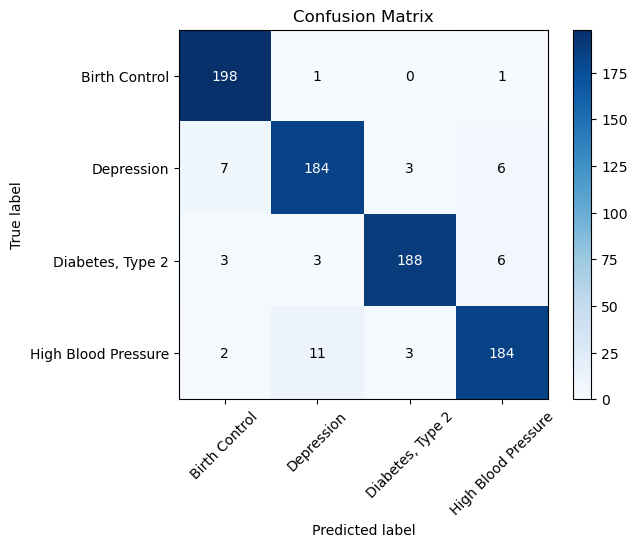

In [12]:
xgb_hypertuned,best_params=hyper_parameter_tuning(X_train,y_train)
pred=predict_on_test_data(xgb_hypertuned,X_test)
pred_proba=predict_prob_on_test_data(xgb_hypertuned,X_test)
print(get_metrics(y_test,pred,pred_proba))
create_confusion_matrix_plot(xgb_hypertuned,X_test,y_test)

# Roc Curve using One vs all test

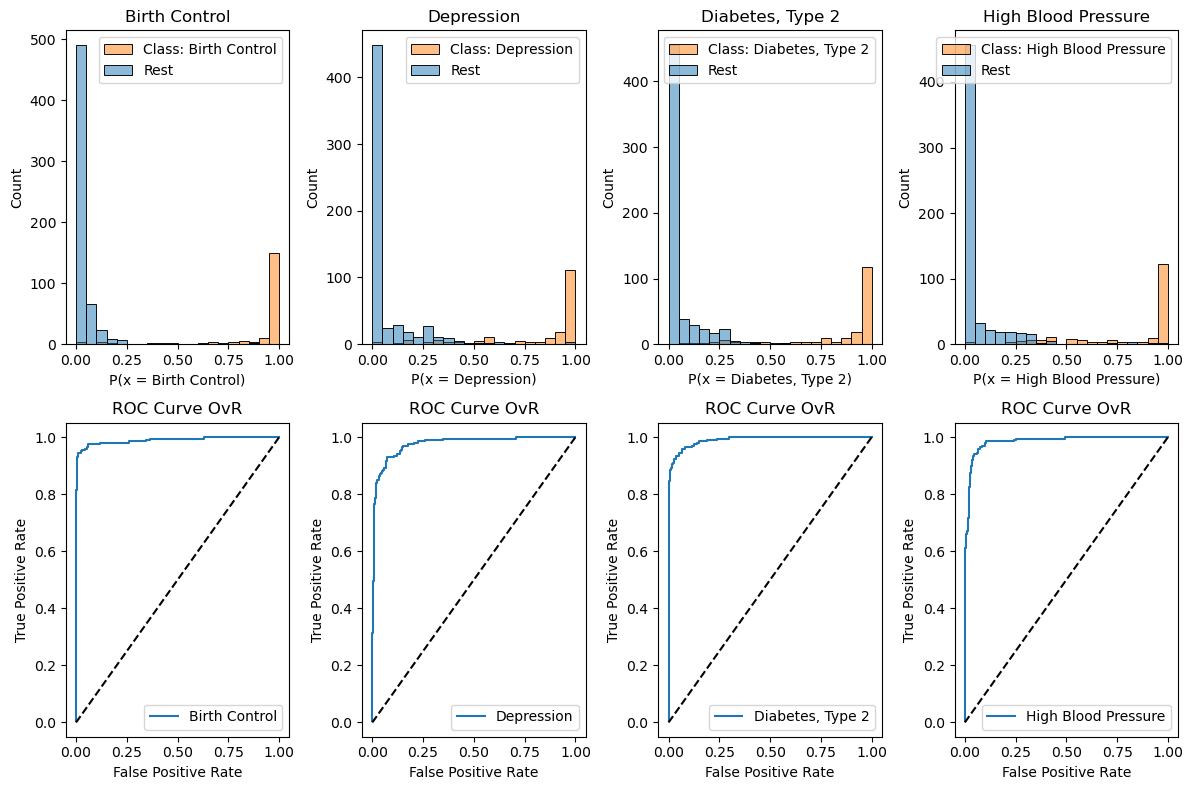

In [20]:
create_roc_auc_plot(xgb,X_test,y_test)